## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell that loads the autoreload extension. This allows us to edit .py source files and re-import them into the notebook for a seamless editing and debugging experience.


In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link and sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: '239AS.3/project1/vae'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '24F-CS260D/project/project code'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['vae project.ipynb', 'vaeProject.py', 'helper.py', '__pycache__', 'evaluator.py']


Once you have successfully mounted your Google Drive and located the path to
this assignment, run the following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from vae.py!
Hello from helper.py!
```

In [4]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

from vaeProject import hello_vae
hello_vae()

from helper import hello_helper
hello_helper()

Hello from vae.py!
Hello from helper.py!


Load several useful packages that are used in this notebook:

In [5]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import matplotlib.pyplot as plt
%matplotlib inline


# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [6]:
if torch.cuda.is_available():
  print('Good to go!')
else:
  print('Please set GPU via the downward triangle in the top right corner.')

Good to go!


## Load SpucoMNIST Dataset

In [7]:
%pip install spuco

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.2/126.2 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.7 MB/s eta 0:00:00
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39588 sha256=91ec28173e984c09c407ac0c080f836c862855904bdac41b1002dbdaee8c768b
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [8]:
from spuco.utils import set_seed

set_seed(1)

In [9]:
from spuco.robust_train import ERM, UpSampleERM
from spuco.datasets import SpuCoMNIST, SpuriousFeatureDifficulty
import torchvision.transforms as T
from enum import Enum


classes = [[0], [1], [2], [3], [4],[5], [6], [7], [8], [9]]
#classes = [[0,1], [2,3], [4,5], [6,7], [8,9]]
difficulty = SpuriousFeatureDifficulty.MAGNITUDE_LARGE

class ColorMap(Enum):
  TAB10 = 'tab10'

trainset = SpuCoMNIST(
    root="/data/mnist/",
    spurious_feature_difficulty=difficulty,
    spurious_correlation_strength=0.99,
    classes=classes,
    split="train",
    label_noise=0.001,
    color_map=ColorMap.TAB10
)
trainset.initialize()

testset = SpuCoMNIST(
    root="/data/mnist/",
    spurious_feature_difficulty=difficulty,
    classes=classes,
    split="test",
    color_map=ColorMap.TAB10
)
testset.initialize()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 48.5MB/s]


Extracting /data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.85MB/s]

Extracting /data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 13.8MB/s]


Extracting /data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.74MB/s]

Extracting /data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



In [17]:
batch_size = 512
loader_train = DataLoader(trainset, batch_size=batch_size,
                           shuffle=True, drop_last=True, num_workers=2)

In [18]:
import torchvision.transforms as T

%cd /content/drive/My\ Drive/$GOOGLE_DRIVE_PATH_AFTER_MYDRIVE


/content/drive/My Drive/24F-CS260D/project/project code


## Visualize dataset

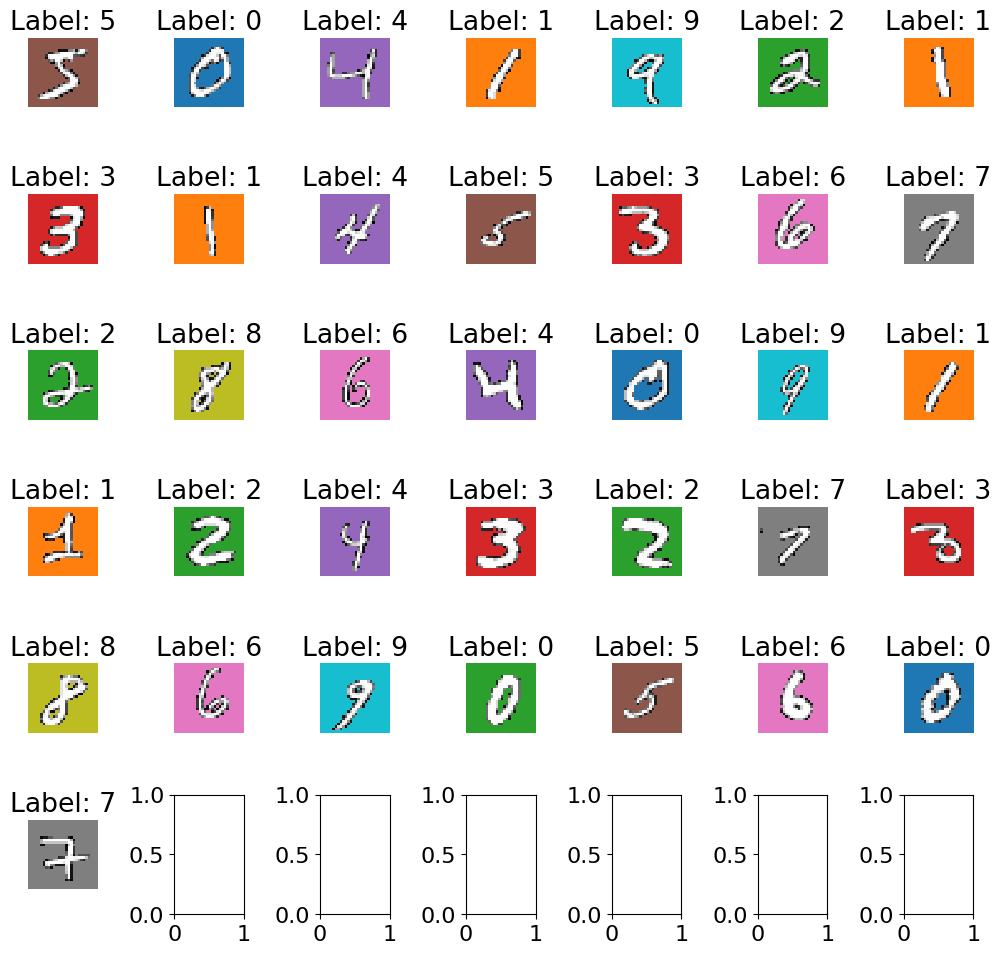

In [19]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
def visualize_dataset(dataset, num_samples=16, is_labeled=False):
    """
    Visualize a grid of samples from the dataset.

    Args:
    - dataset: The dataset to visualize.
    - num_samples: Number of samples to display.
    """
    grid_size = int(num_samples**0.5)
    fig, axes = plt.subplots(grid_size, grid_size+1, figsize=(10,10))

    for i, ax in enumerate(axes.flat):
        if i >= num_samples:
            break

        if is_labeled:
          img, label = dataset[i]
        else:
          img = dataset[i]
        pil_img = T.ToPILImage()(img)
        ax.imshow(pil_img, cmap="gray")
        if is_labeled:
          ax.set_title(f"Label: {label}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()
# Visualize samples from the training set
visualize_dataset(trainset, num_samples=36, is_labeled=True)

# Upsample Block

In [ ]:
#upsample
from spuco.utils import CustomIndicesSampler, Trainer
from vaeProject import upsampleGroups
indices = upsampleGroups(trainset.group_partition)
sampler = CustomIndicesSampler(indices=indices, shuffle=True)

batch_size = 512
loader_train = DataLoader(trainset, batch_size=batch_size,
                            drop_last=True, num_workers=2, sampler=sampler)

# VAE Block

In [21]:
#VAE
num_epochs = 15
latent_size = 19
from vaeProject import VAE
from helper import train_vae
input_size = 28*28*3
device = 'cuda'
vae_model = VAE(input_size, latent_size=latent_size)
vae_model.cuda()
for epoch in range(0, num_epochs):
  train_vae(epoch, vae_model, loader_train)

Train Epoch: 0 	Loss: 1423.908569, total:136366.859375
Train Epoch: 1 	Loss: 1344.549438, total:130634.6484375
Train Epoch: 2 	Loss: 1337.517334, total:125972.6484375
Train Epoch: 3 	Loss: 1318.342163, total:124295.4765625
Train Epoch: 4 	Loss: 1328.485352, total:124256.515625
Train Epoch: 5 	Loss: 1320.538330, total:123351.6328125
Train Epoch: 6 	Loss: 1320.573364, total:122973.9765625
Train Epoch: 7 	Loss: 1312.007080, total:123001.3984375
Train Epoch: 8 	Loss: 1320.068237, total:122953.703125
Train Epoch: 9 	Loss: 1315.991333, total:122833.640625
Train Epoch: 10 	Loss: 1334.942139, total:122479.1640625
Train Epoch: 11 	Loss: 1327.795532, total:122410.078125
Train Epoch: 12 	Loss: 1313.625977, total:122300.0078125
Train Epoch: 13 	Loss: 1299.821411, total:122532.203125
Train Epoch: 14 	Loss: 1317.720215, total:122103.0


# Evaluate VAE

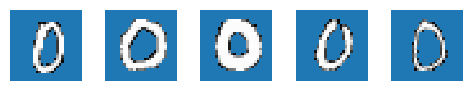

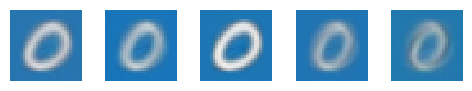

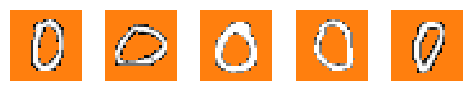

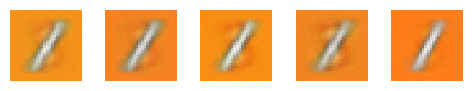

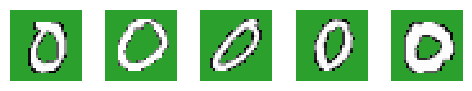

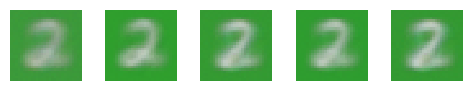

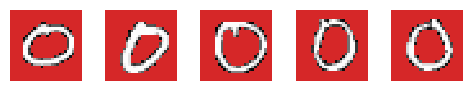

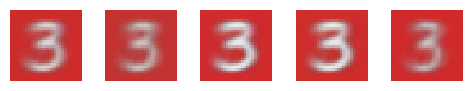

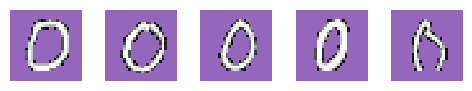

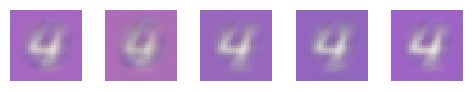

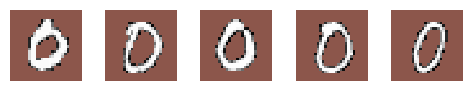

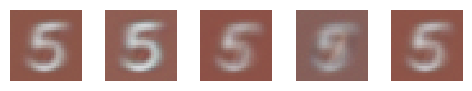

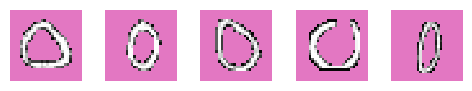

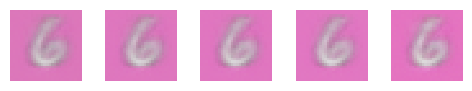

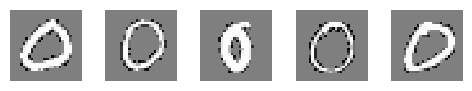

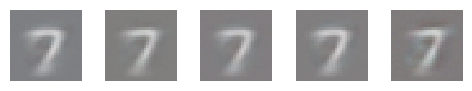

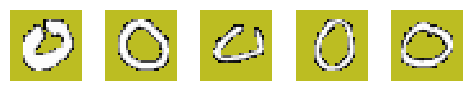

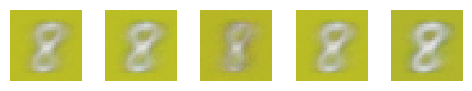

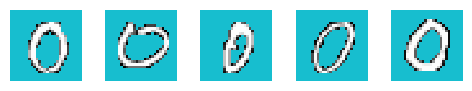

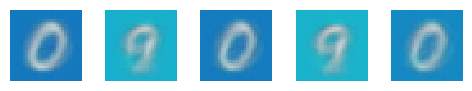

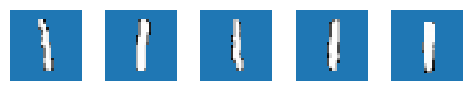

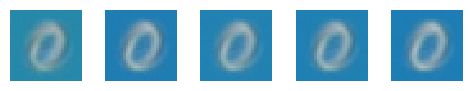

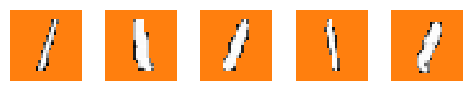

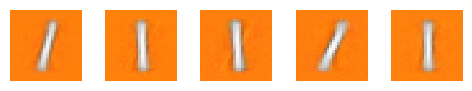

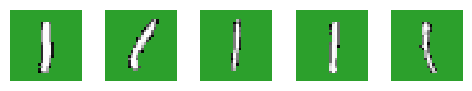

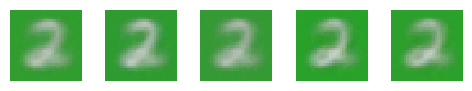

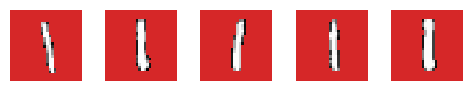

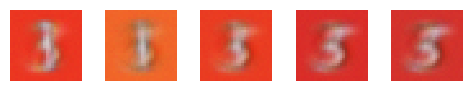

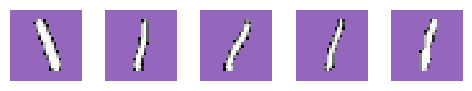

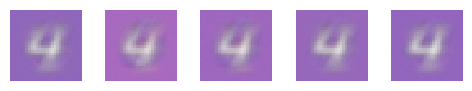

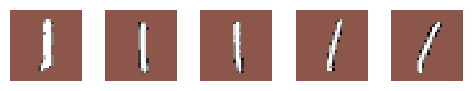

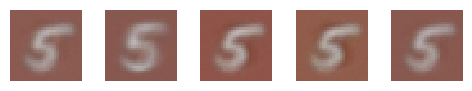

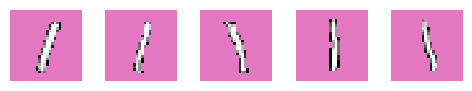

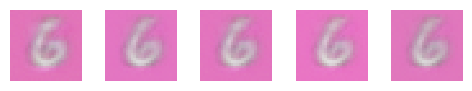

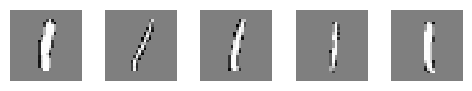

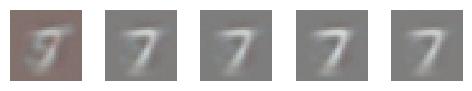

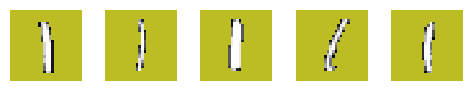

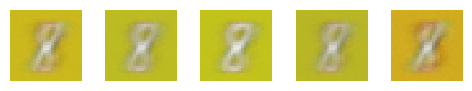

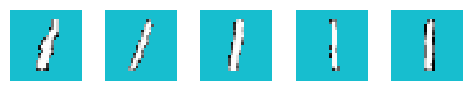

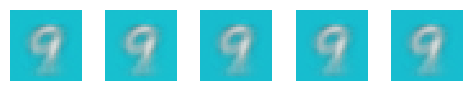

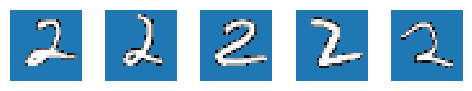

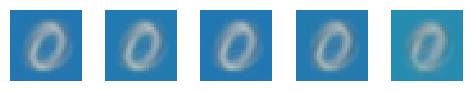

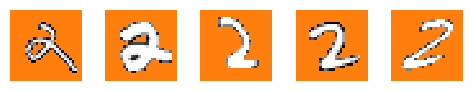

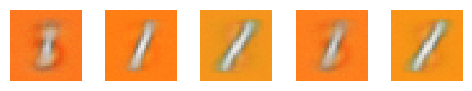

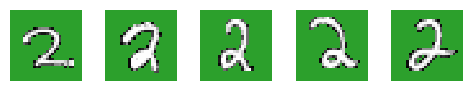

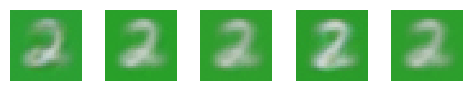

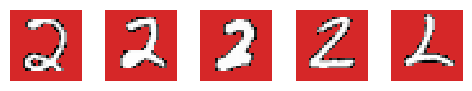

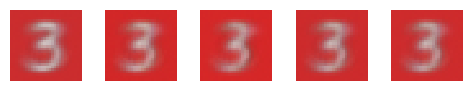

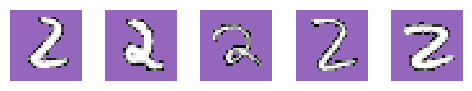

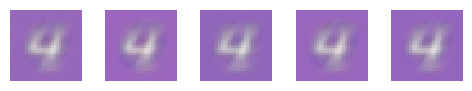

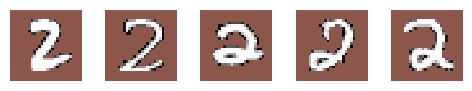

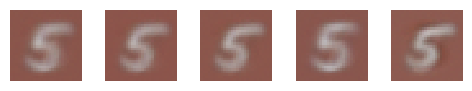

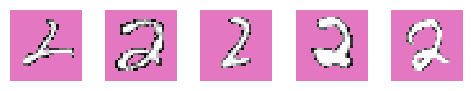

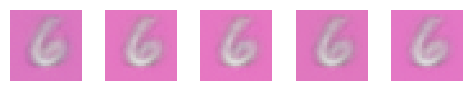

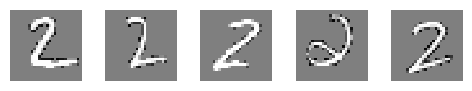

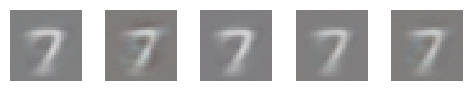

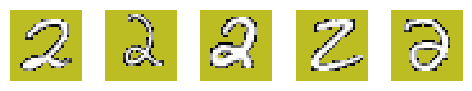

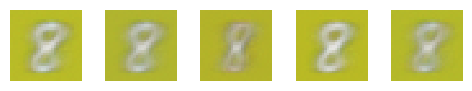

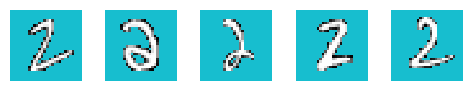

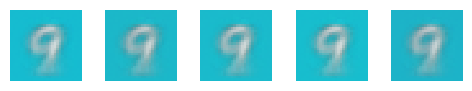

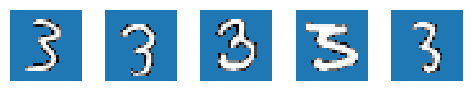

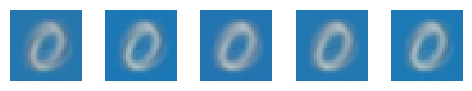

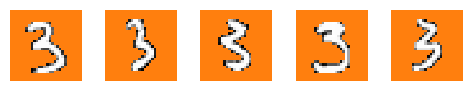

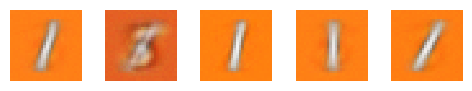

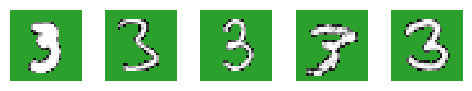

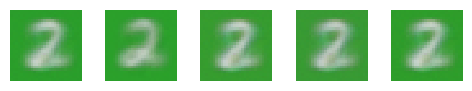

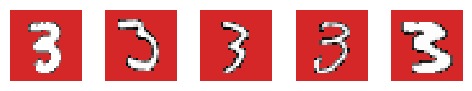

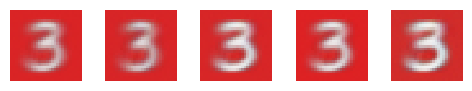

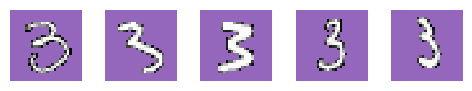

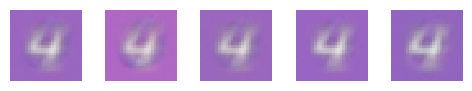

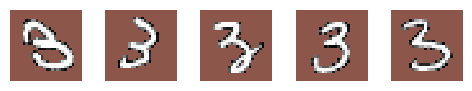

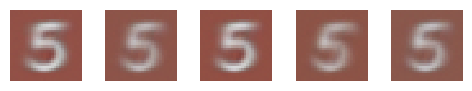

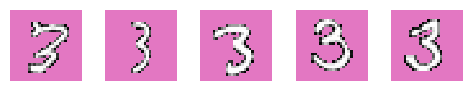

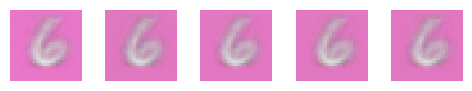

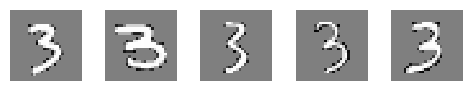

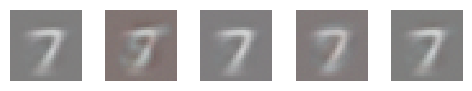

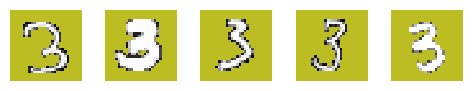

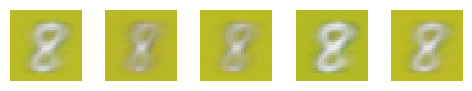

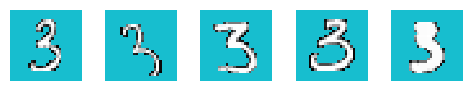

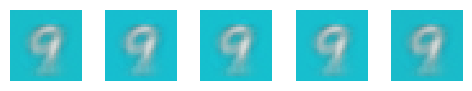

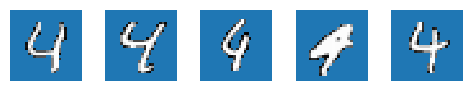

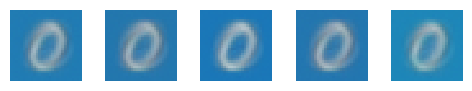

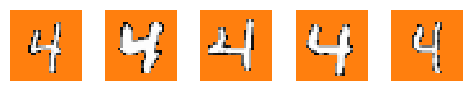

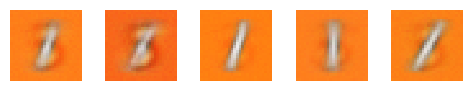

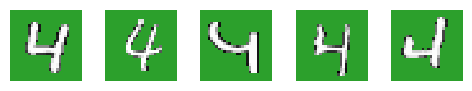

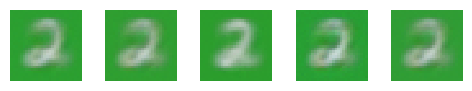

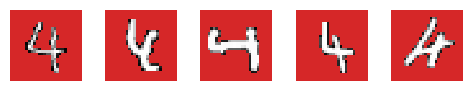

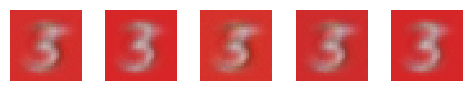

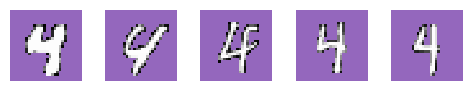

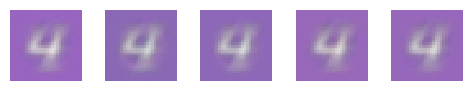

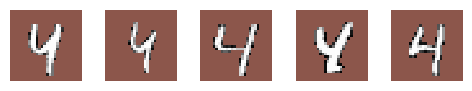

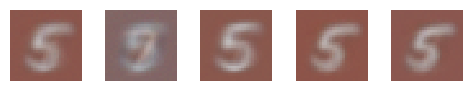

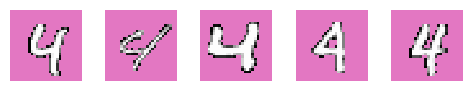

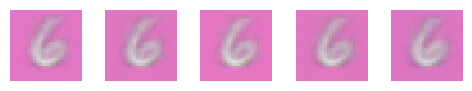

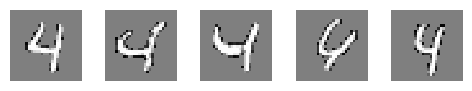

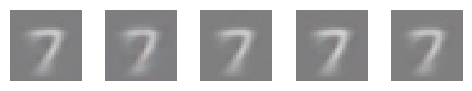

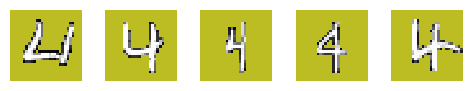

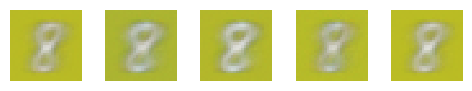

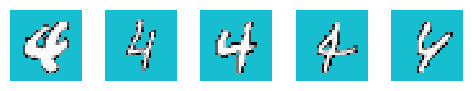

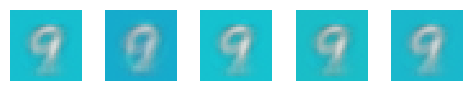

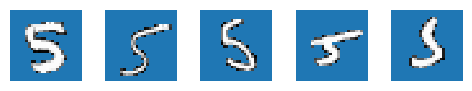

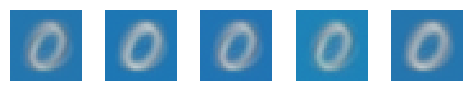

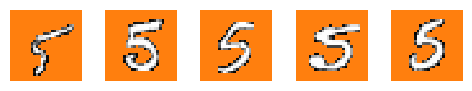

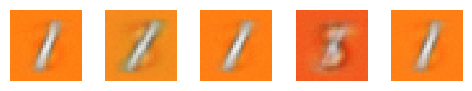

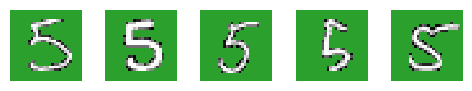

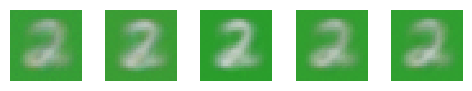

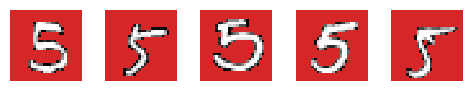

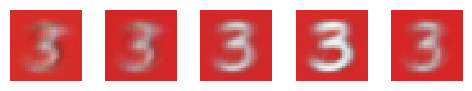

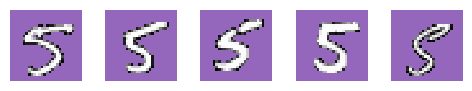

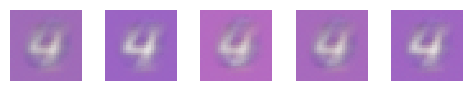

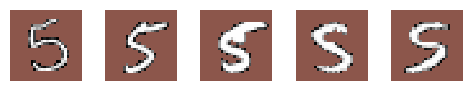

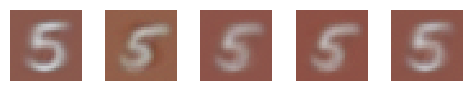

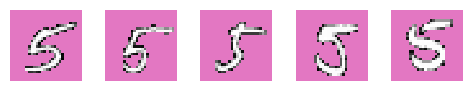

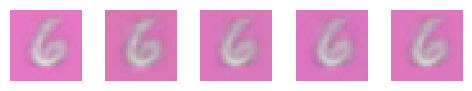

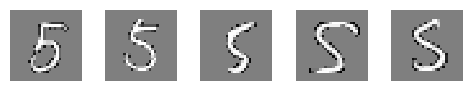

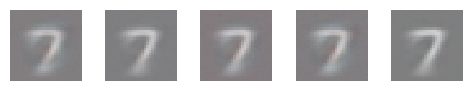

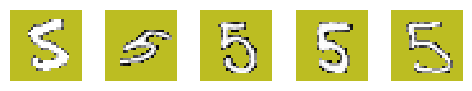

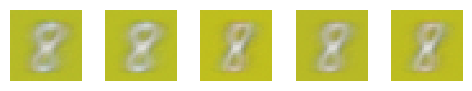

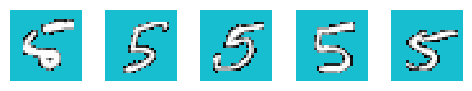

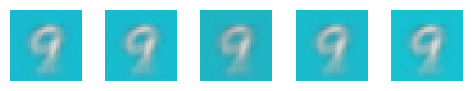

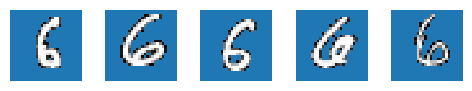

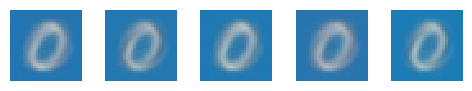

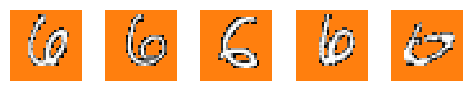

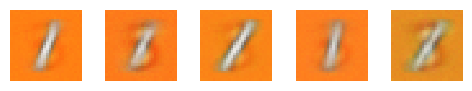

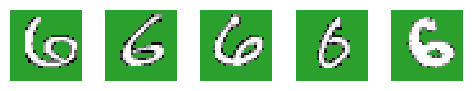

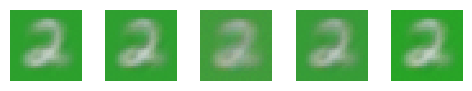

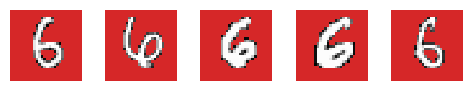

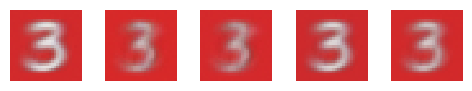

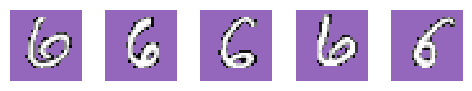

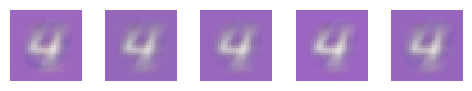

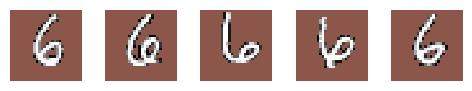

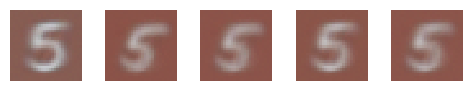

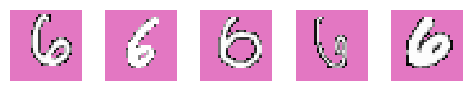

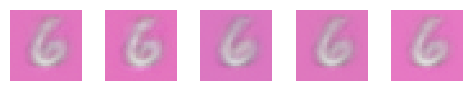

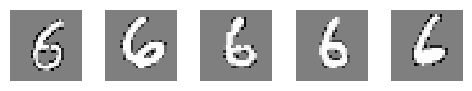

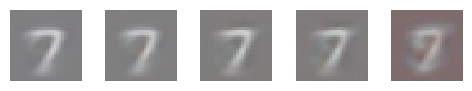

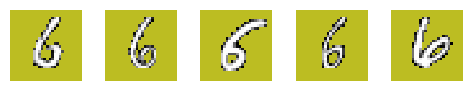

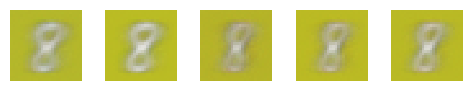

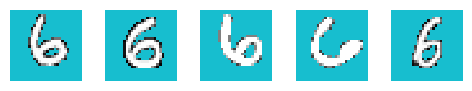

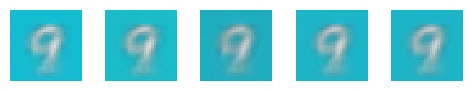

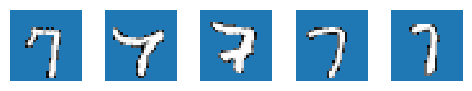

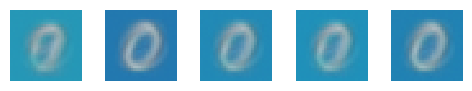

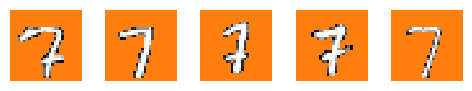

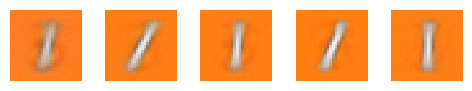

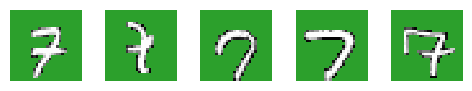

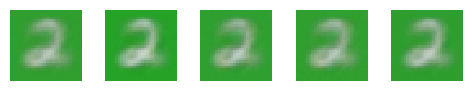

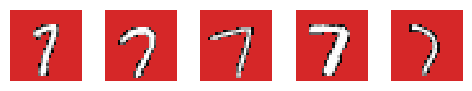

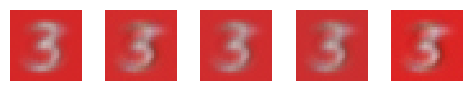

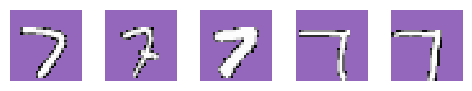

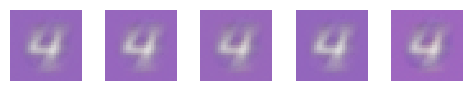

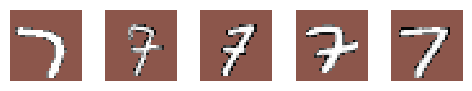

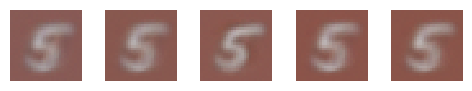

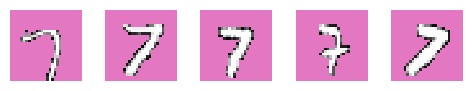

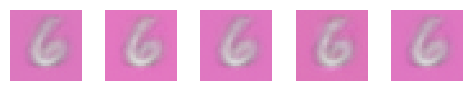

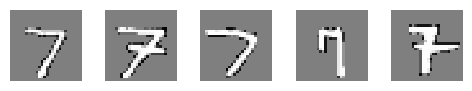

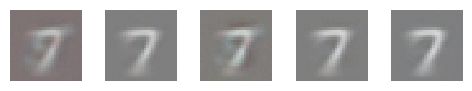

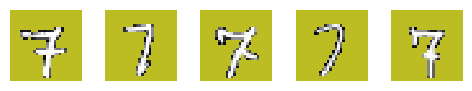

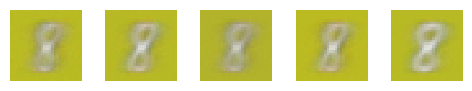

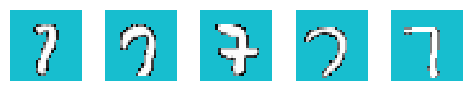

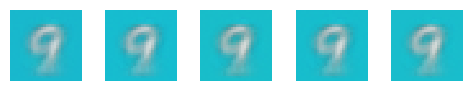

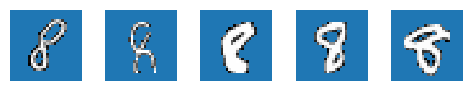

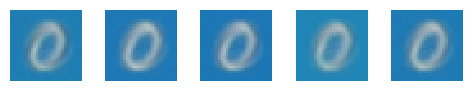

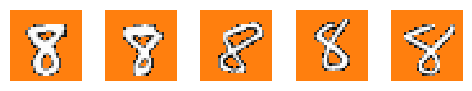

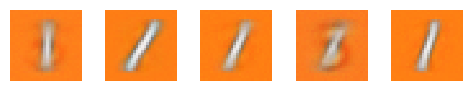

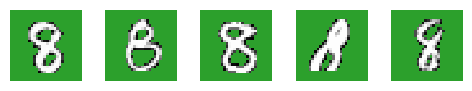

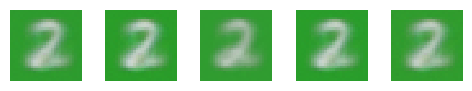

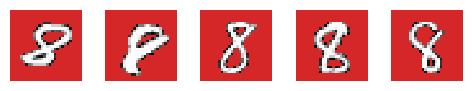

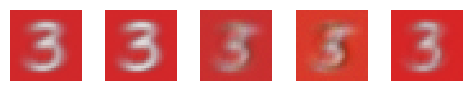

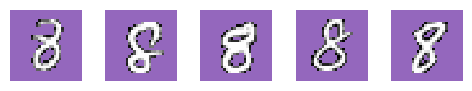

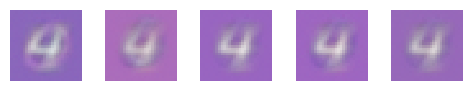

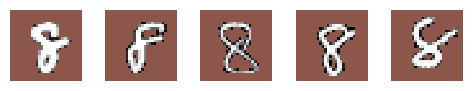

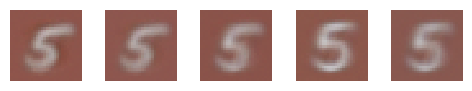

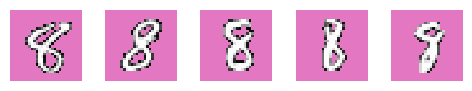

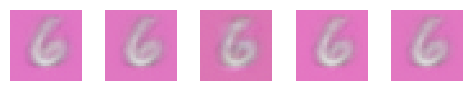

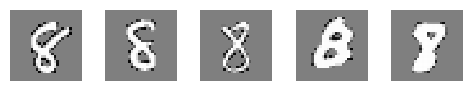

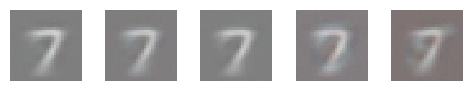

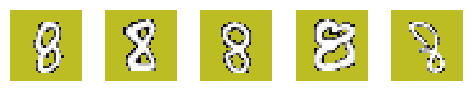

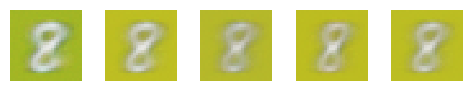

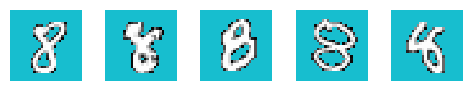

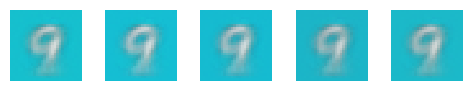

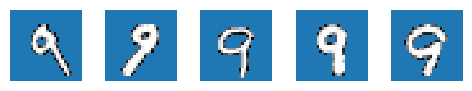

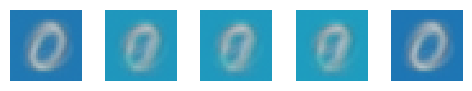

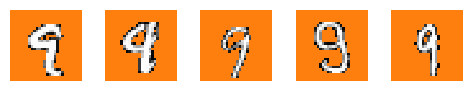

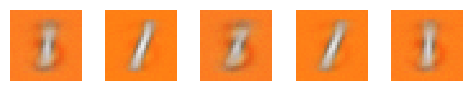

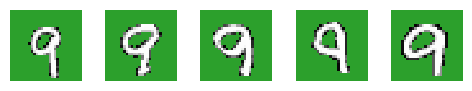

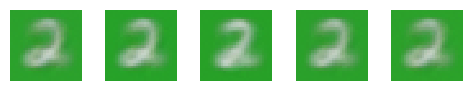

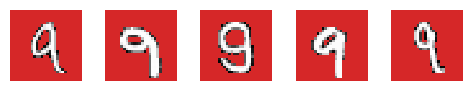

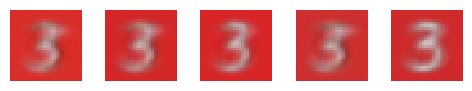

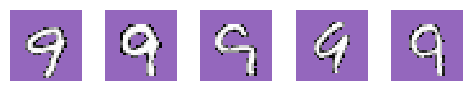

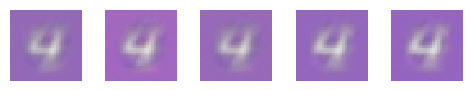

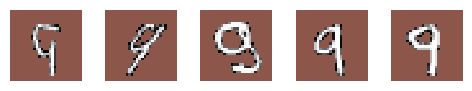

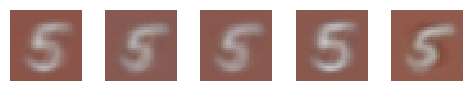

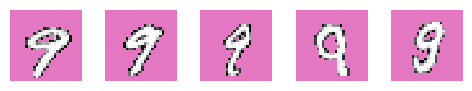

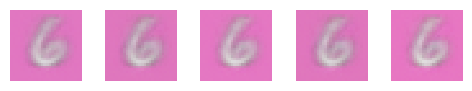

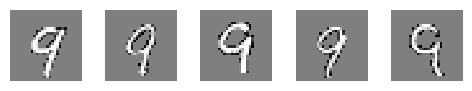

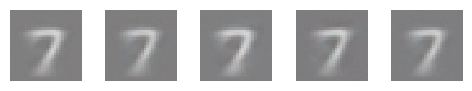

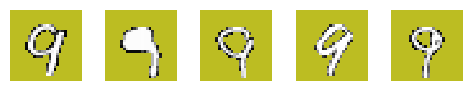

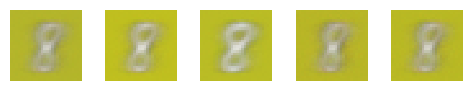

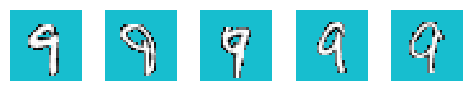

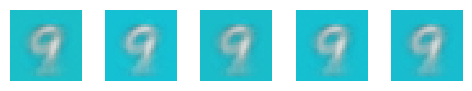

In [23]:
from evaluator import Evaluator

evaluator = Evaluator(
    testset=testset,
    group_partition=testset.group_partition,
    group_weights=trainset.group_weights,
    batch_size=512,
    model=vae_model,
    device=device,
    verbose=False,
)
evaluator.evaluate()

# Convolutional VAE Block

In [25]:
#VAEConv
num_epochs = 15
latent_size = 19
from vaeProject import VAEConv
from helper import train_vae
input_size = 28*28*3
device = 'cuda'
vae_conv_model = VAEConv()
vae_conv_model.cuda()
for epoch in range(0, num_epochs):
  train_vae(epoch, vae_conv_model, loader_train)

Train Epoch: 0 	Loss: 1360.906250, total:130891.5859375
Train Epoch: 1 	Loss: 1352.656250, total:127025.1484375
Train Epoch: 2 	Loss: 1335.459106, total:125272.421875
Train Epoch: 3 	Loss: 1328.466797, total:124516.1953125
Train Epoch: 4 	Loss: 1325.104980, total:123595.0390625
Train Epoch: 5 	Loss: 1316.517334, total:123123.2578125
Train Epoch: 6 	Loss: 1305.141846, total:122652.8046875
Train Epoch: 7 	Loss: 1293.697754, total:122344.8671875
Train Epoch: 8 	Loss: 1310.145386, total:121993.9765625
Train Epoch: 9 	Loss: 1309.573730, total:121854.875
Train Epoch: 10 	Loss: 1294.640991, total:121576.234375
Train Epoch: 11 	Loss: 1305.945679, total:121455.1328125
Train Epoch: 12 	Loss: 1287.228638, total:121308.53125
Train Epoch: 13 	Loss: 1298.484497, total:121141.65625
Train Epoch: 14 	Loss: 1302.741333, total:121057.5859375


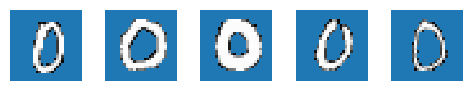

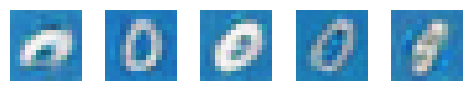

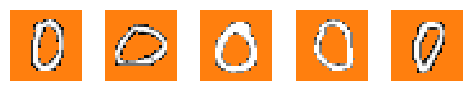

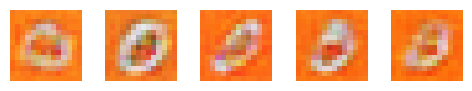

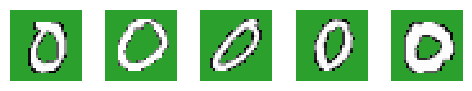

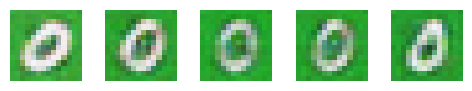

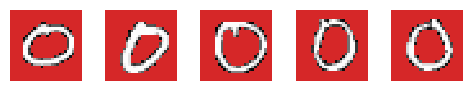

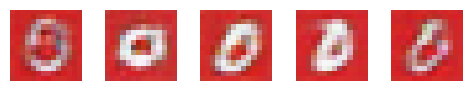

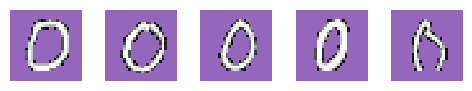

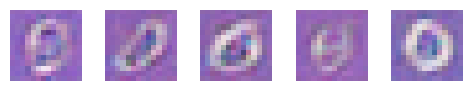

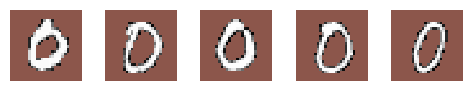

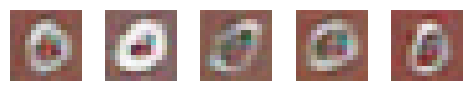

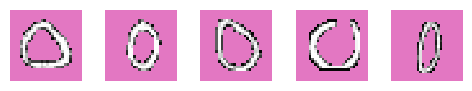

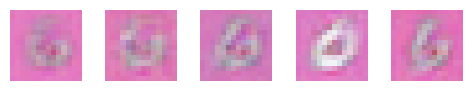

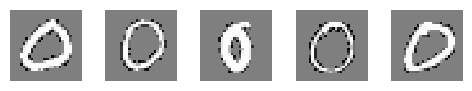

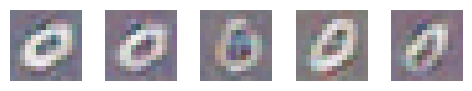

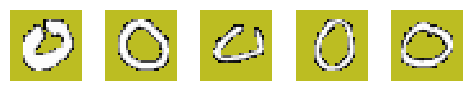

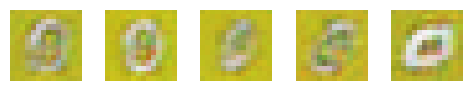

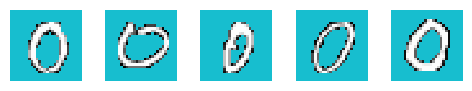

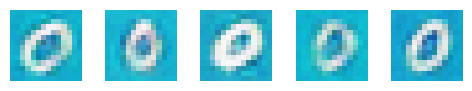

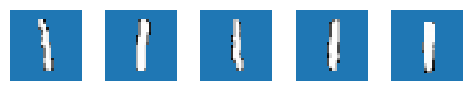

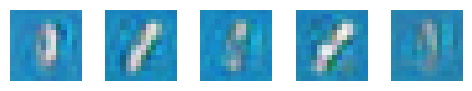

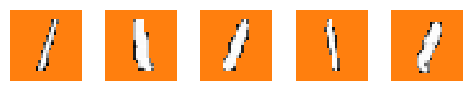

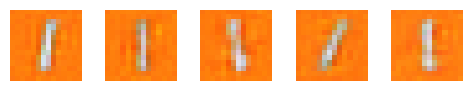

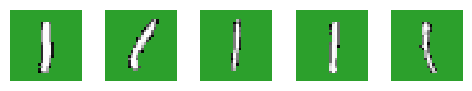

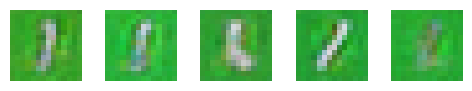

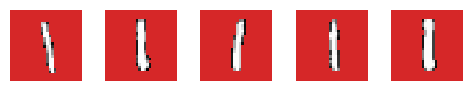

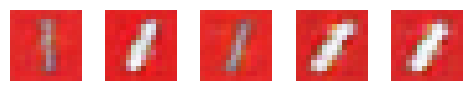

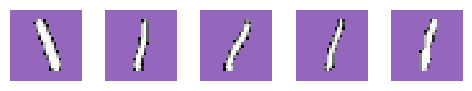

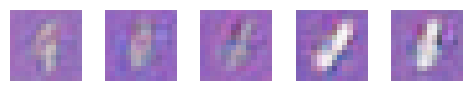

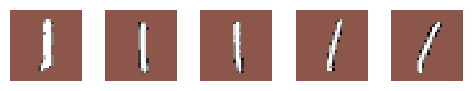

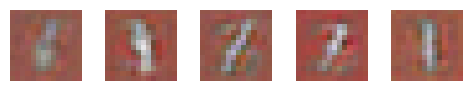

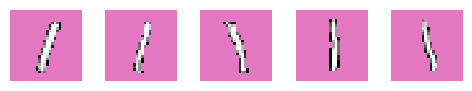

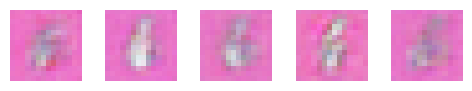

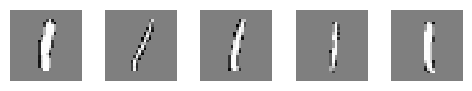

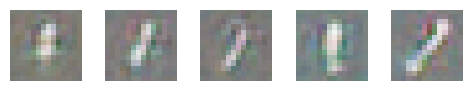

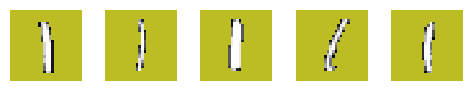

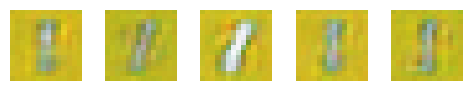

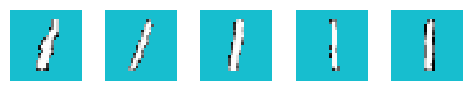

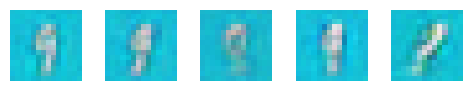

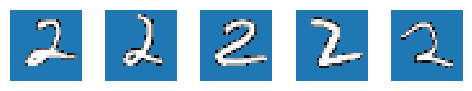

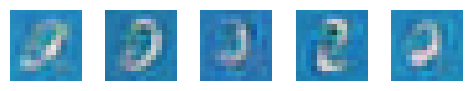

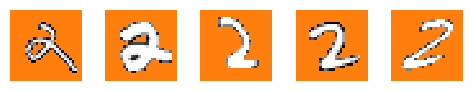

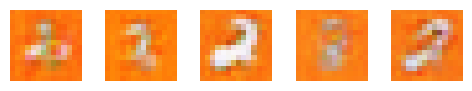

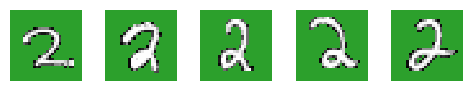

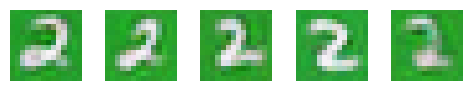

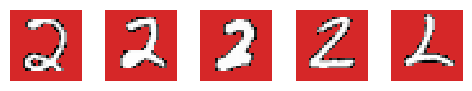

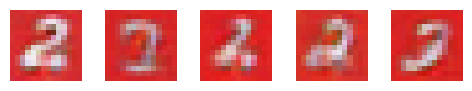

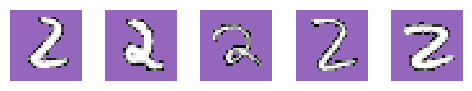

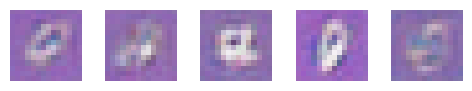

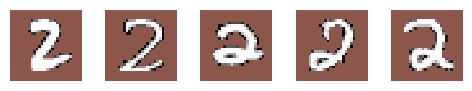

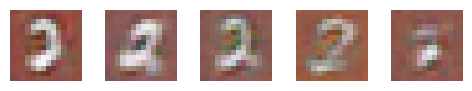

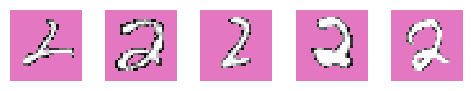

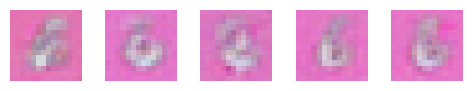

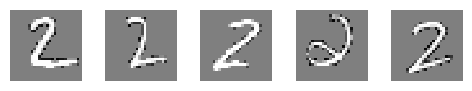

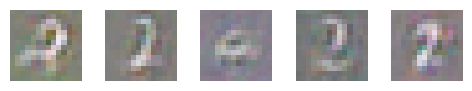

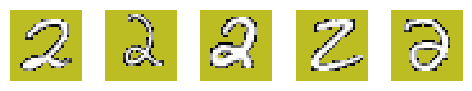

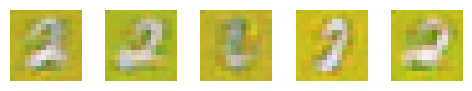

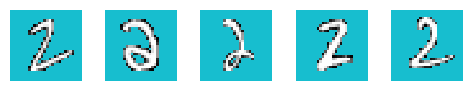

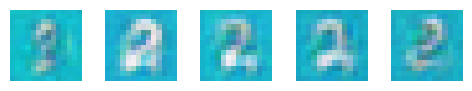

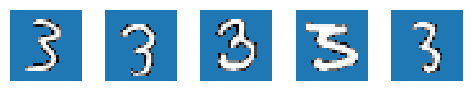

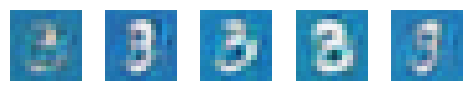

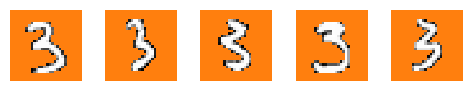

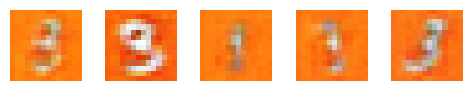

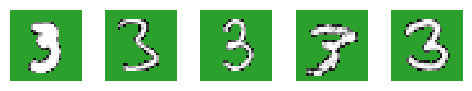

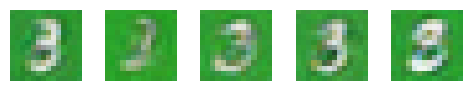

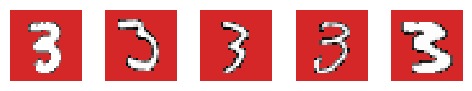

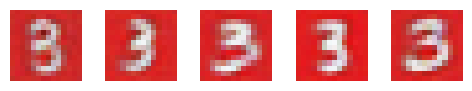

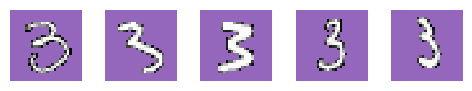

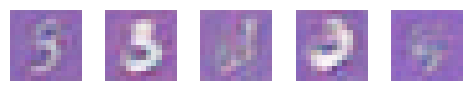

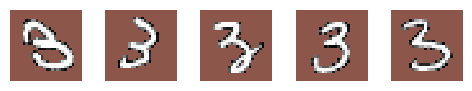

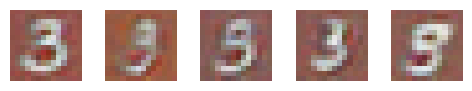

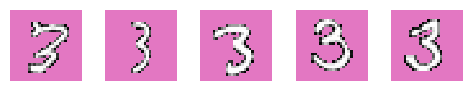

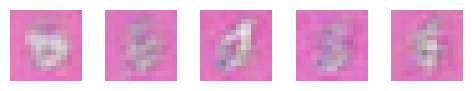

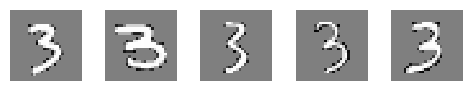

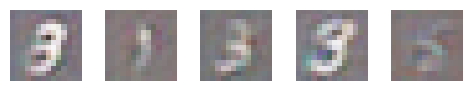

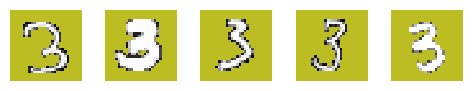

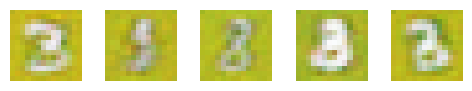

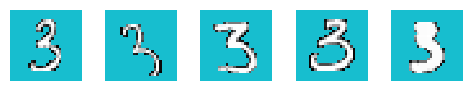

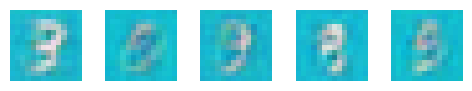

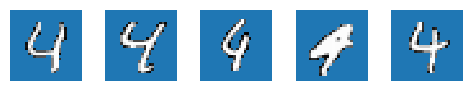

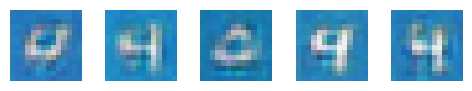

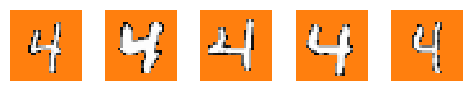

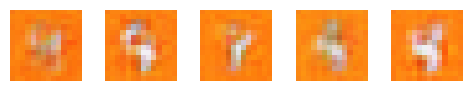

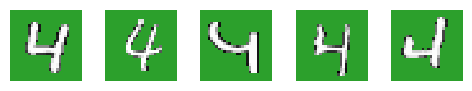

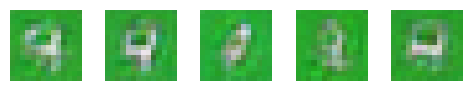

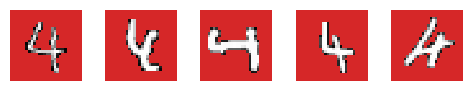

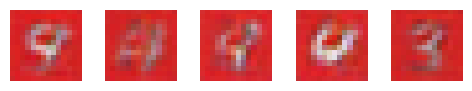

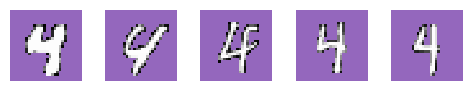

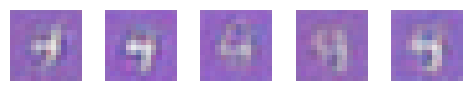

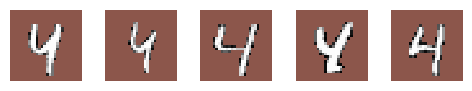

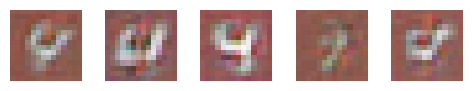

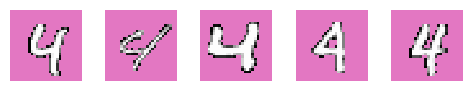

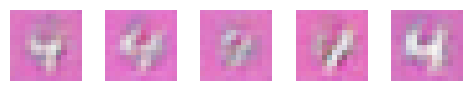

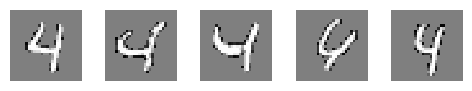

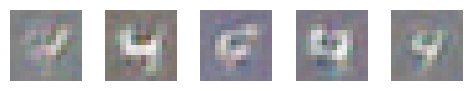

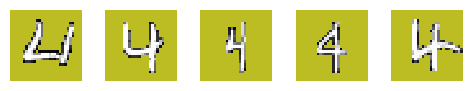

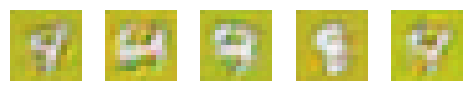

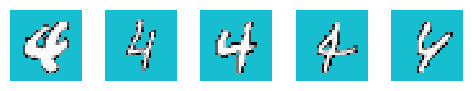

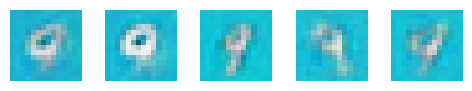

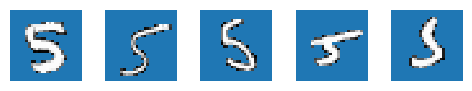

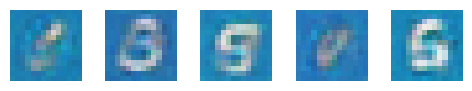

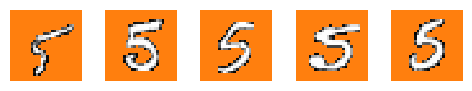

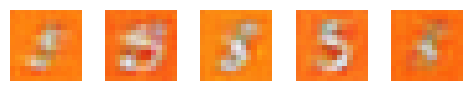

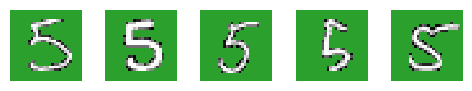

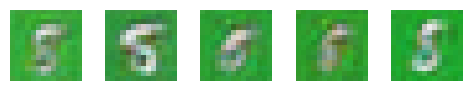

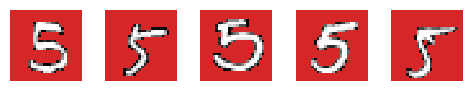

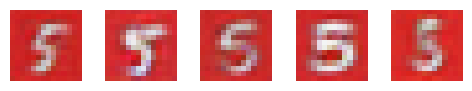

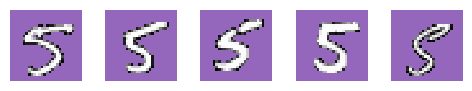

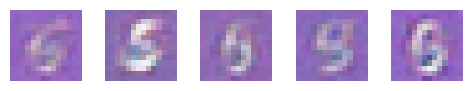

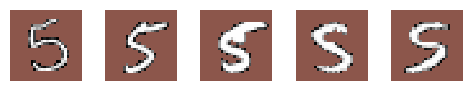

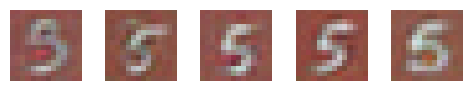

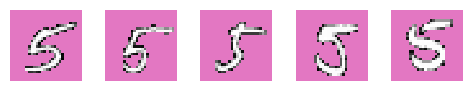

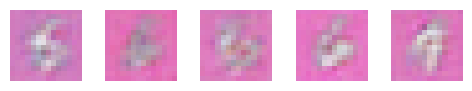

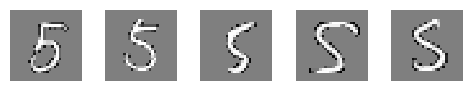

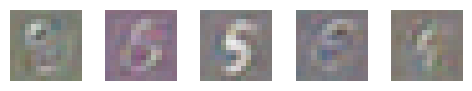

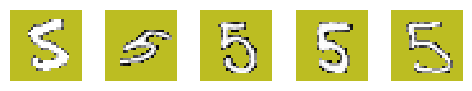

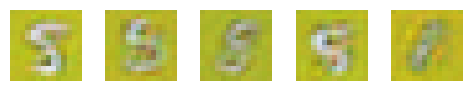

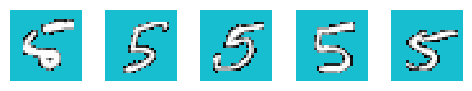

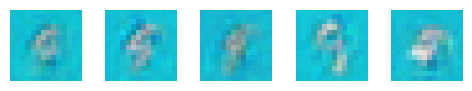

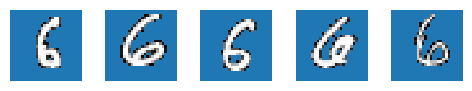

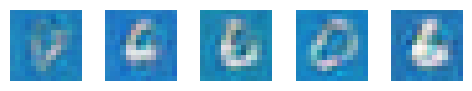

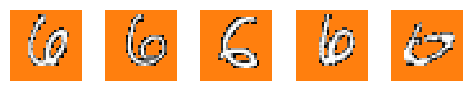

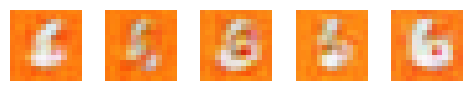

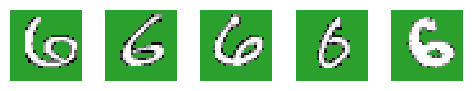

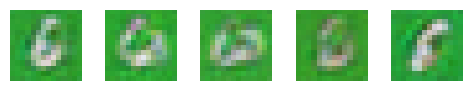

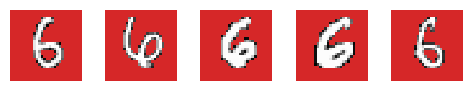

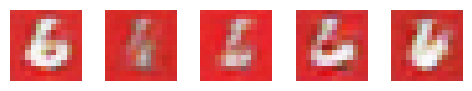

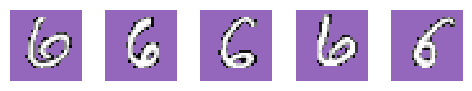

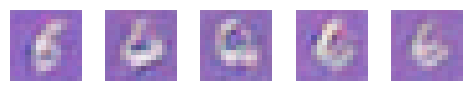

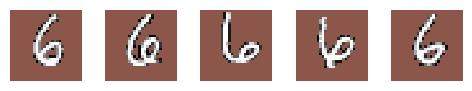

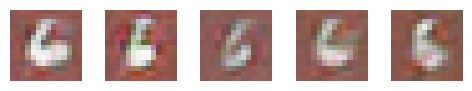

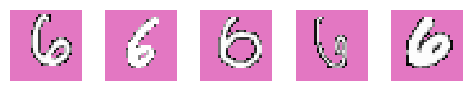

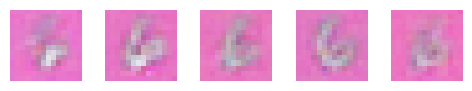

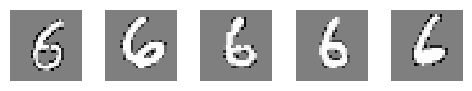

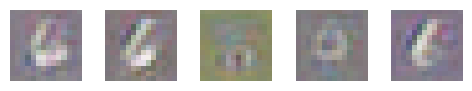

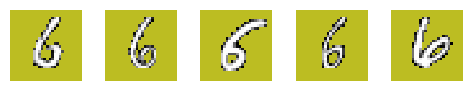

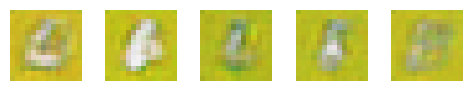

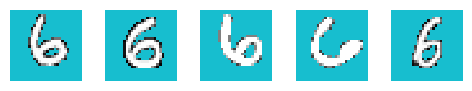

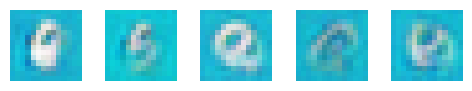

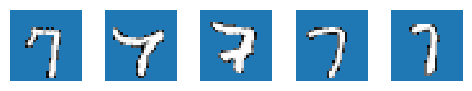

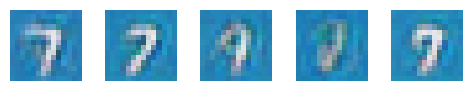

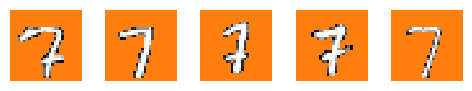

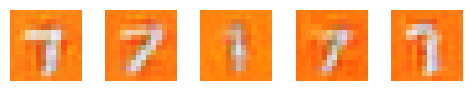

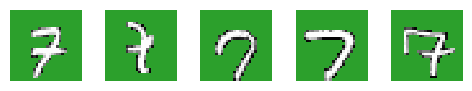

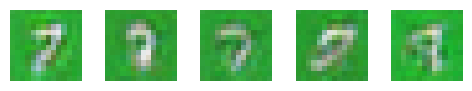

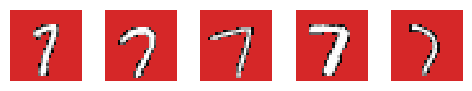

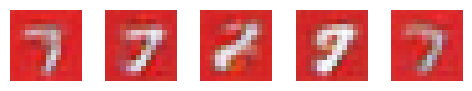

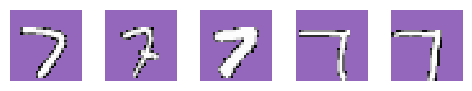

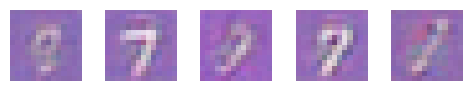

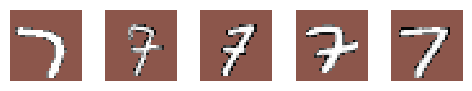

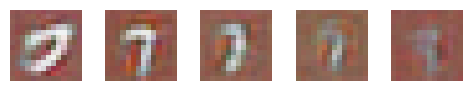

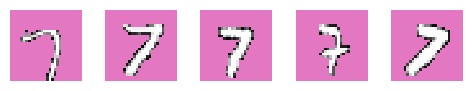

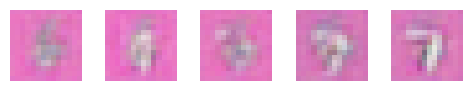

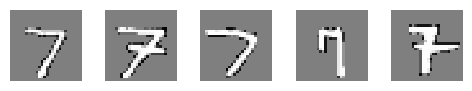

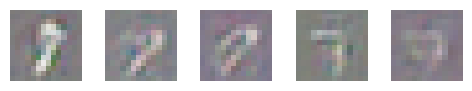

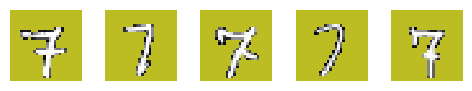

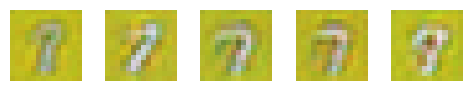

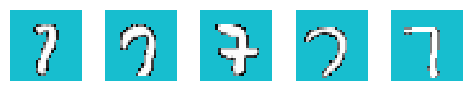

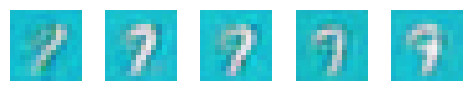

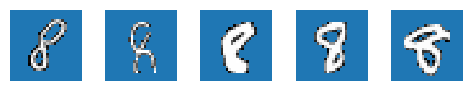

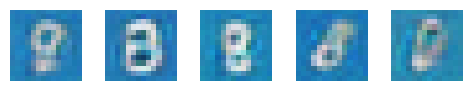

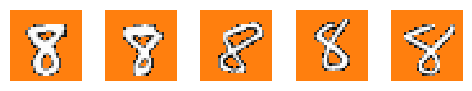

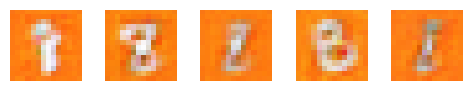

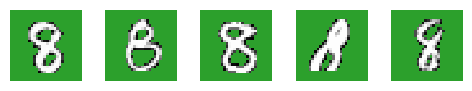

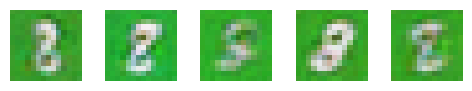

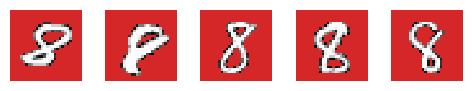

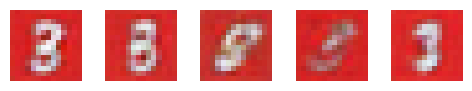

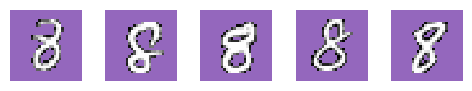

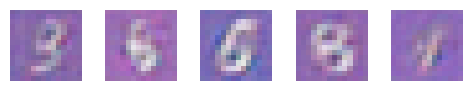

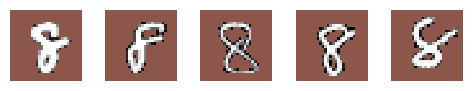

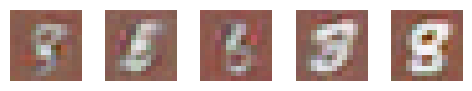

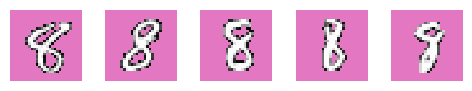

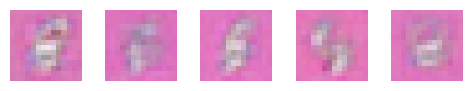

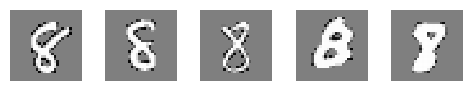

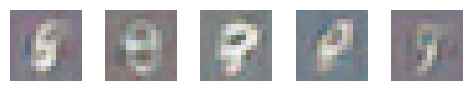

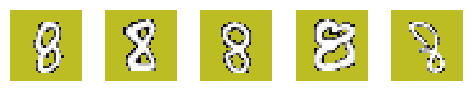

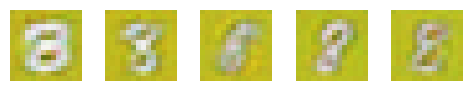

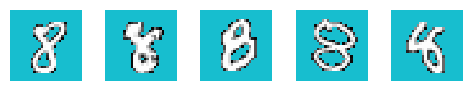

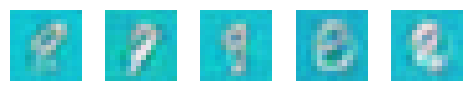

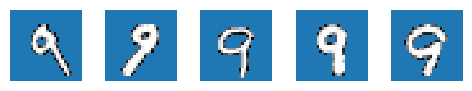

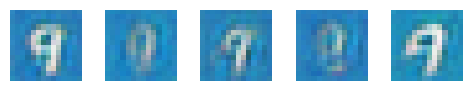

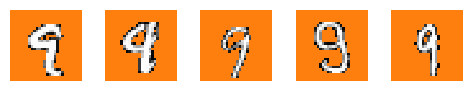

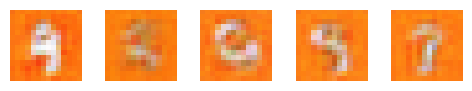

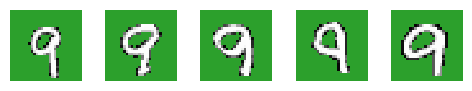

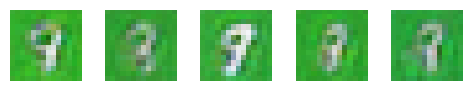

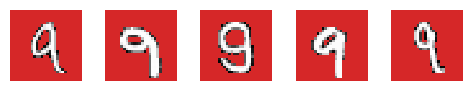

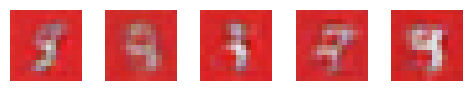

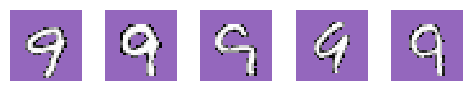

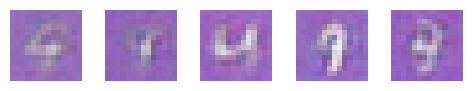

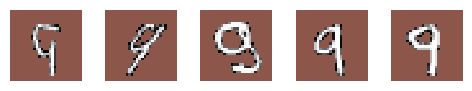

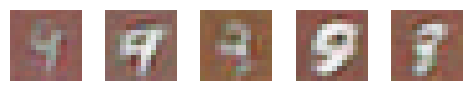

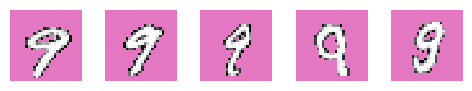

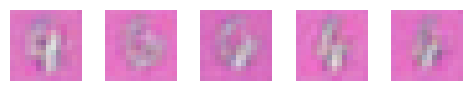

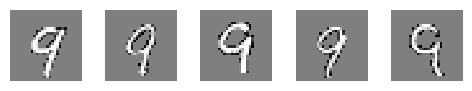

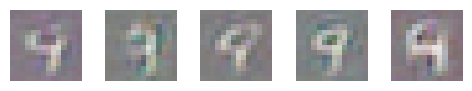

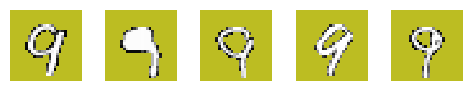

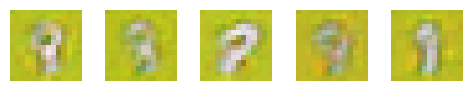

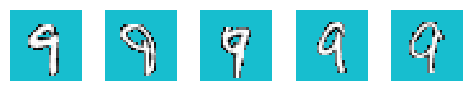

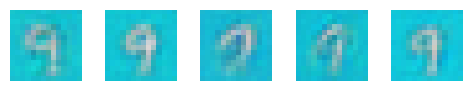

In [27]:
from evaluator import Evaluator
#Print Groups With Sizes
# def myFunc(t):
#   return (t[0], t[1])
# sorted_keys = sorted(trainset.group_partition.keys(), key=myFunc)
# for key in sorted_keys:
#   print(f"group: {key}, count: {len(trainset.group_partition[key])}")

evaluator = Evaluator(
    testset=testset,
    group_partition=testset.group_partition,
    group_weights=trainset.group_weights,
    batch_size=512,
    model=vae_conv_model,
    device=device,
    verbose=False,
    #vanilla = True
)
evaluator.evaluate()